In [1]:
from data_process.svhn_data import *
from data_process.mnist_data import *
from data_process.visualization import *
import matplotlib.pyplot as plt
from mcd_svhn2mnist_Mom import *

# Domain Adaptation between SVHN Data and MNIST Data using Maximum Classifier Discrepency

## Data Preparation

In [2]:
svhn_images_train, svhn_labels_train_hot, svhn_images_test, svhn_labels_test_hot = load_svhn_data(hot = True)
svhn_images_train, svhn_labels_train, svhn_images_test, svhn_labels_test = load_svhn_data(hot = False)

In [3]:
svhn_images_train_greyscale = rgb2gray(svhn_images_train).astype(np.float32)
svhn_images_test_greyscale = rgb2gray(svhn_images_test).astype(np.float32)

In [4]:
mnist_images_train, mnist_labels_train, mnist_images_test, mnist_labels_test = load_mnist_data(32)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


/home/ecbm4040/miniconda3/envs/dlenv/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ecbm4040/miniconda3/envs/dlenv/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [5]:
print(svhn_images_train.shape)
print(svhn_images_train_greyscale.shape)
print(svhn_labels_train.shape)
print(svhn_labels_train_hot.shape)
print(svhn_images_test.shape)
print(svhn_images_test_greyscale.shape)
print(svhn_labels_test.shape)
print(svhn_labels_test_hot.shape)


print(mnist_images_train.shape)
print(mnist_labels_train.shape)
print(mnist_images_test.shape)
print(mnist_labels_test.shape)



(73257, 32, 32, 3)
(73257, 32, 32, 1)
(73257,)
(73257, 10)
(26032, 32, 32, 3)
(26032, 32, 32, 1)
(26032,)
(26032, 10)
(55000, 32, 32, 1)
(55000, 10)
(10000, 32, 32, 1)
(10000, 10)


## Data Visualization

### SVHN Data

In [6]:
# Calculate the total number of images in source dataset
num_images = svhn_images_train.shape[0] + svhn_images_test.shape[0]

print("Total Number of Images", num_images)

Total Number of Images 99289


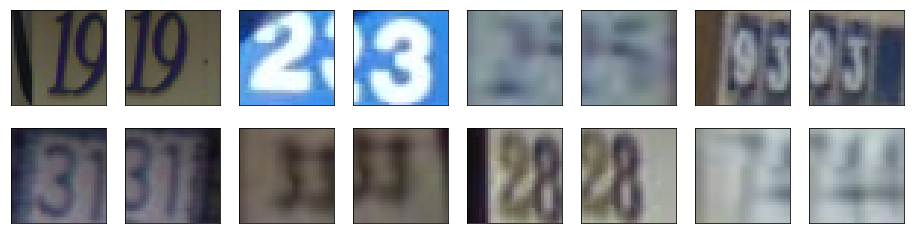

In [7]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

# plot some images in training set
plot_images(svhn_images_train, 2, 8)

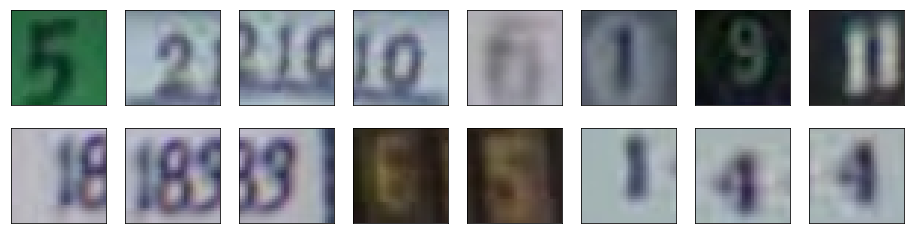

In [8]:
# plot some images in test set
plt.rcParams['figure.figsize'] = (16.0, 4.0)
plot_images(svhn_images_test, 2, 8)

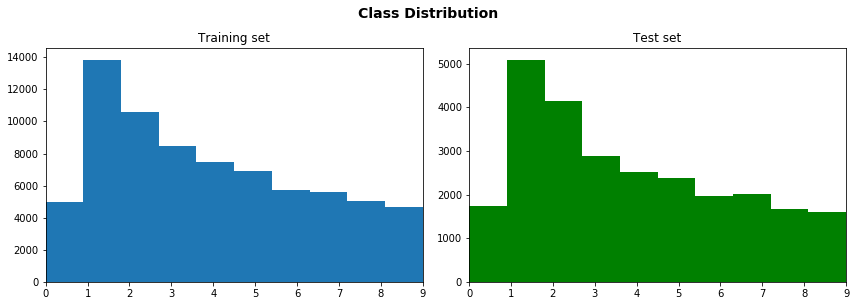

In [9]:
plt.rcParams['figure.figsize'] = (12.0, 4.0)
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(svhn_labels_train, bins=10)
ax1.set_title("Training set")
ax1.set_xlim(0, 9)

ax2.hist(svhn_labels_test, color='g', bins=10)
ax2.set_title("Test set")

fig.tight_layout()

### MNIST Data

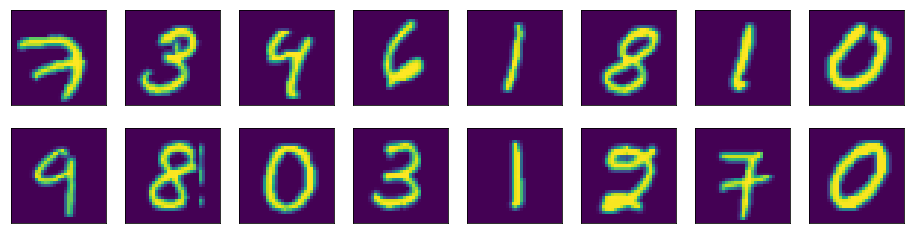

In [10]:
plt.rcParams['figure.figsize'] = (16.0, 4.0)
plot_images(mnist_images_train, 2, 8)

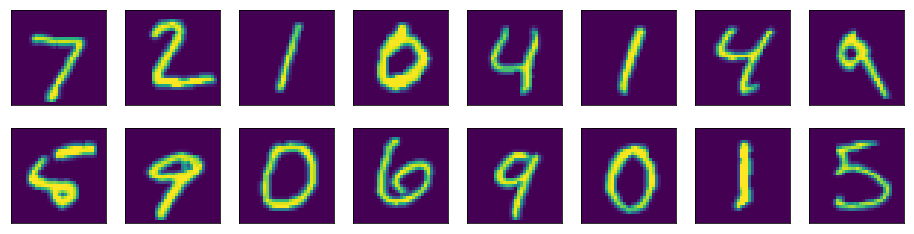

In [11]:
plt.rcParams['figure.figsize'] = (16.0, 4.0)
plot_images(mnist_images_test, 2, 8)

## Sampling Data

In [12]:
ind_1 = np.random.choice(73257, 60000, replace = False)
ind_2 = np.random.choice(16032, 5000, replace = False)

svhn_tr_im = svhn_images_train_greyscale[ind_1,:,:]
svhn_tr_im = np.reshape(svhn_tr_im, (-1, 1024))
svhn_ts_im = svhn_images_test_greyscale[ind_2,:,:]
svhn_ts_im = np.reshape(svhn_ts_im, (-1, 1024))
svhn_tr_labels = svhn_labels_train_hot[ind_1,:]
svhn_ts_labels = svhn_labels_test_hot[ind_2,:]

ind_3 = np.random.choice(55000, 20000, replace = False)
ind_4 = np.random.choice(10000, 5000, replace = False)

mnist_tr_im = mnist_images_train[ind_3,:,:]
mnist_tr_im = np.reshape(mnist_tr_im, (-1, 1024))
mnist_ts_im = mnist_images_test[ind_4,:,:]
mnist_ts_im = np.reshape(mnist_ts_im, (-1, 1024))
mnist_tr_labels = mnist_labels_train[ind_3,:]
mnist_ts_labels = mnist_labels_test[ind_4,:]


In [13]:
filter_size = 5
n_filters_1 = 64
n_filters_2 = 64
n_filters_3 = 128
n_units_g = 3072
n_units_c = 2048
#n_units_d_1 = 64
#n_units_d_2 = 64
learning_rate = 0.0002
epoch = 40
num_stepC = 3
#n_iter = 1000
batch_size = 64
show_step = 50
model_path = '/model'
#keep_prob = 0.8

is_saving = False

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

number of batches for training: 312
epoch 1 
---------------
Iteration: 0, Loss_test_a: 4.67591990568699, Loss_test_b: 4.6493011972843075, Loss_test_c: 0.028259849707142282
Source test acc1: 12.484975961538462%, Source test acc2: 11.207932692307693%.
Best test accuracy classifier1! Iteration:0 accuracy: 10.391626602564102%
Best test accuracy classifier2! Iteration:0 accuracy: 10.486778846153847%
---------------
Iteration: 50, Loss_test_a: 4.315735101699829, Loss_test_b: 4.292040716379117, Loss_test_c: 0.022680956553906586
Source test acc1: 24.899839743589745%, Source test acc2: 24.539262820512818%.
Best test accuracy classifier1! Iteration:50 accuracy: 21.69971955128205%
Best test accuracy classifier2! Iteration:50 accuracy: 20.13721955128205%
---------------
Iteration: 100, Loss_test_a: 3.6148852

---------------
Iteration: 1136, Loss_test_a: 0.934780284189261, Loss_test_b: 0.9299730590711801, Loss_test_c: 0.007830970666896647
Source test acc1: 85.59695512820514%, Source test acc2: 85.6270032051282%.
---------------
Iteration: 1186, Loss_test_a: 0.952307750399296, Loss_test_b: 0.9469347461484946, Loss_test_c: 0.008134947419584466
Source test acc1: 85.0410657051282%, Source test acc2: 84.97095352564102%.
---------------
Iteration: 1236, Loss_test_a: 0.9238369912864306, Loss_test_b: 0.9148054995024816, Loss_test_c: 0.007886899621763196
Source test acc1: 86.0526842948718%, Source test acc2: 85.85236378205127%.
epoch 5 
---------------
Iteration: 1248, Loss_test_a: 0.8945292165646186, Loss_test_b: 0.8875227684202867, Loss_test_c: 0.007778187721179655
Source test acc1: 86.55849358974359%, Source test acc2: 86.51342147435898%.
---------------
Iteration: 1298, Loss_test_a: 0.9140499862722862, Loss_test_b: 0.9056853986321352, Loss_test_c: 0.007645785038431103
Source test acc1: 85.882411

---------------
Iteration: 2484, Loss_test_a: 0.7910737805068493, Loss_test_b: 0.7839805613725613, Loss_test_c: 0.005816098671251287
Source test acc1: 88.22115384615384%, Source test acc2: 88.33133012820514%.
epoch 9 
---------------
Iteration: 2496, Loss_test_a: 0.7841228702320502, Loss_test_b: 0.7784519385641966, Loss_test_c: 0.0056604820808085305
Source test acc1: 88.26121794871796%, Source test acc2: 88.29126602564102%.
---------------
Iteration: 2546, Loss_test_a: 0.7534601722772305, Loss_test_b: 0.7443656571543752, Loss_test_c: 0.005935056812655277
Source test acc1: 88.68689903846155%, Source test acc2: 88.61678685897436%.
---------------
Iteration: 2596, Loss_test_a: 0.7581388273109229, Loss_test_b: 0.754506245542031, Loss_test_c: 0.005538872951337208
Source test acc1: 88.3563701923077%, Source test acc2: 88.48657852564102%.
---------------
Iteration: 2646, Loss_test_a: 0.7611202398458352, Loss_test_b: 0.7558200253316989, Loss_test_c: 0.005431716263186759
Source test acc1: 88.49

Iteration: 3994, Loss_test_a: 0.6900869040296246, Loss_test_b: 0.6905792020500089, Loss_test_c: 0.004343191174438032
Source test acc1: 89.88882211538461%, Source test acc2: 89.95392628205127%.
---------------
Iteration: 4044, Loss_test_a: 0.6954703682030623, Loss_test_b: 0.6909058109307901, Loss_test_c: 0.004412502351512488
Source test acc1: 89.77363782051282%, Source test acc2: 89.71854967948718%.
epoch 14 
---------------
Iteration: 4056, Loss_test_a: 0.6974168142351584, Loss_test_b: 0.6880860733680236, Loss_test_c: 0.004434813788975589
Source test acc1: 89.82371794871796%, Source test acc2: 89.80869391025641%.
---------------
Iteration: 4106, Loss_test_a: 0.7358643658554707, Loss_test_b: 0.7321245966909024, Loss_test_c: 0.00443741917096747
Source test acc1: 89.2177483974359%, Source test acc2: 89.01742788461539%.
Best test accuracy classifier1! Iteration:4106 accuracy: 81.31009615384616%
---------------
Iteration: 4156, Loss_test_a: 0.7054933181080298, Loss_test_b: 0.700571646245244

---------------
Iteration: 5504, Loss_test_a: 0.6496446451458794, Loss_test_b: 0.6402902203874711, Loss_test_c: 0.0036840394056455875
Source test acc1: 90.7802483974359%, Source test acc2: 90.625%.
---------------
Iteration: 5554, Loss_test_a: 0.6298915414282908, Loss_test_b: 0.627052269040201, Loss_test_c: 0.0036367938241127352
Source test acc1: 90.85536858974359%, Source test acc2: 90.92548076923077%.
Best test accuracy classifier1! Iteration:5554 accuracy: 83.49358974358975%
Best test accuracy classifier2! Iteration:5554 accuracy: 83.62379807692307%
---------------
Iteration: 5604, Loss_test_a: 0.626163037493825, Loss_test_b: 0.621049257950523, Loss_test_c: 0.0037974981603791746
Source test acc1: 91.07071314102564%, Source test acc2: 90.85536858974359%.
epoch 19 
---------------
Iteration: 5616, Loss_test_a: 0.6423738966576564, Loss_test_b: 0.6381924330280759, Loss_test_c: 0.003772794511557246
Source test acc1: 90.7802483974359%, Source test acc2: 90.65504807692307%.
---------------

---------------
Iteration: 7114, Loss_test_a: 0.5992689822585537, Loss_test_b: 0.5962538134354429, Loss_test_c: 0.0030751565992921735
Source test acc1: 91.47135416666666%, Source test acc2: 91.36117788461539%.
---------------
Iteration: 7164, Loss_test_a: 0.5900000316353563, Loss_test_b: 0.5835265116049693, Loss_test_c: 0.00293235603282646
Source test acc1: 91.4813701923077%, Source test acc2: 91.60657051282051%.
epoch 24 
---------------
Iteration: 7176, Loss_test_a: 0.591351707215206, Loss_test_b: 0.5864290045096706, Loss_test_c: 0.0029520658020210713
Source test acc1: 91.46634615384616%, Source test acc2: 91.45132211538461%.
Best test accuracy classifier2! Iteration:7176 accuracy: 84.55028044871796%
---------------
Iteration: 7226, Loss_test_a: 0.610094803576477, Loss_test_b: 0.6067852377652739, Loss_test_c: 0.0028695007388775525
Source test acc1: 91.3261217948718%, Source test acc2: 91.05068108974359%.
---------------
Iteration: 7276, Loss_test_a: 0.6154867102129337, Loss_test_b: 0

---------------
Iteration: 8724, Loss_test_a: 0.5922590252728417, Loss_test_b: 0.5941911584530504, Loss_test_c: 0.00264446362677681
Source test acc1: 91.61157852564102%, Source test acc2: 91.50641025641025%.
Best test accuracy classifier1! Iteration:8724 accuracy: 85.8223157051282%
Best test accuracy classifier2! Iteration:8724 accuracy: 85.68709935897436%
epoch 29 
---------------
Iteration: 8736, Loss_test_a: 0.6102846146394045, Loss_test_b: 0.6081436733261515, Loss_test_c: 0.002722524449778482
Source test acc1: 91.23597756410257%, Source test acc2: 91.22596153846155%.
---------------
Iteration: 8786, Loss_test_a: 0.5971583231734351, Loss_test_b: 0.5916279937164524, Loss_test_c: 0.002656392977932671
Source test acc1: 91.56650641025641%, Source test acc2: 91.47135416666666%.
---------------
Iteration: 8836, Loss_test_a: 0.5993809666699514, Loss_test_b: 0.5930190900913798, Loss_test_c: 0.0027164224591568853
Source test acc1: 91.3261217948718%, Source test acc2: 91.22095352564102%.
----

---------------
Iteration: 10396, Loss_test_a: 0.5849100891500711, Loss_test_b: 0.5861178223903363, Loss_test_c: 0.0023114645123431007
Source test acc1: 91.96714743589743%, Source test acc2: 92.02223557692307%.
---------------
Iteration: 10446, Loss_test_a: 0.6055440055743719, Loss_test_b: 0.603260184912823, Loss_test_c: 0.002334064523426768
Source test acc1: 91.88701923076923%, Source test acc2: 91.92708333333334%.
---------------
Iteration: 10496, Loss_test_a: 0.5731365500758283, Loss_test_b: 0.5720324300659391, Loss_test_c: 0.00240575509628681
Source test acc1: 92.17748397435898%, Source test acc2: 92.03725961538461%.
---------------
Iteration: 10546, Loss_test_a: 0.5863963413792543, Loss_test_b: 0.5818365437504, Loss_test_c: 0.0023758029536297843
Source test acc1: 91.85196314102564%, Source test acc2: 91.73177083333334%.
---------------
Iteration: 10596, Loss_test_a: 0.5823008326383737, Loss_test_b: 0.5816659055745754, Loss_test_c: 0.0022723273039632775
Source test acc1: 92.0823317

---------------
Iteration: 12006, Loss_test_a: 0.5756247359065291, Loss_test_b: 0.5718264910153662, Loss_test_c: 0.002130342168619301
Source test acc1: 92.38782051282051%, Source test acc2: 92.17247596153845%.
---------------
Iteration: 12056, Loss_test_a: 0.5884603779428662, Loss_test_b: 0.5845093288912605, Loss_test_c: 0.0021415159004764296
Source test acc1: 92.29767628205127%, Source test acc2: 92.2626201923077%.
Best test accuracy classifier1! Iteration:12056 accuracy: 86.65865384615384%
---------------
Iteration: 12106, Loss_test_a: 0.5856077763944482, Loss_test_b: 0.5831070055540365, Loss_test_c: 0.0021408409118474736
Source test acc1: 92.27263621794873%, Source test acc2: 92.00721153846155%.
---------------
Iteration: 12156, Loss_test_a: 0.5902071062188882, Loss_test_b: 0.5874832904634949, Loss_test_c: 0.0019493607142067049
Source test acc1: 92.04727564102564%, Source test acc2: 92.00721153846155%.
epoch 40 
---------------
Iteration: 12168, Loss_test_a: 0.5853079508703488, Loss

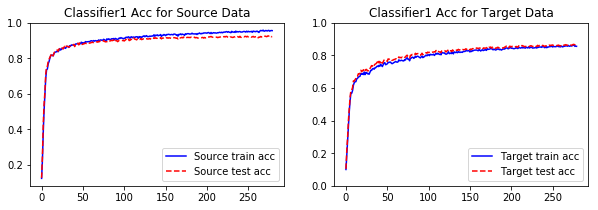

---------------


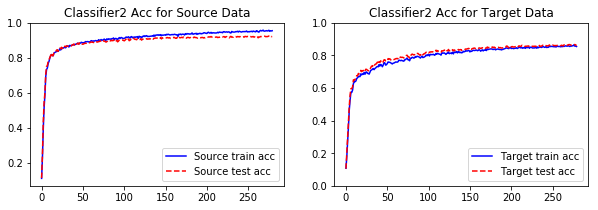

In [14]:

mcd = MCD_DA()
mcd.train(images_train_1=svhn_tr_im, labels_train_1=svhn_tr_labels, \
          images_test_1=svhn_ts_im, labels_test_1=svhn_ts_labels, \
          images_train_t=mnist_tr_im, labels_train_t=mnist_tr_labels, \
          images_test_t=mnist_ts_im, labels_test_t=mnist_ts_labels, \
          filter_size=filter_size, n_filters_1=n_filters_1, n_filters_2=n_filters_2, n_filters_3 = n_filters_3, \
          n_units_g=n_units_g, n_units_c = n_units_c, \
          learning_rate = learning_rate, epoch = epoch, num_stepC = num_stepC, \
          batch_size = batch_size, show_step = show_step, \
          is_saving = is_saving, model_path = model_path)